In [1]:
!pip install kaggle
from google.colab import files

# Upload the Kaggle API key file
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aritra04","key":"5ba27430704a45d1392f4eaaa5a502ba"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

100% 3.57G/3.58G [00:28<00:00, 194MB/s]
100% 3.58G/3.58G [00:29<00:00, 132MB/s]


In [4]:
!unzip -q real-life-violence-situations-dataset.zip -d ./real-life-violence-situations-dataset

In [5]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt

# TF
import tensorflow as tf
from tensorflow import keras
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

<ipython-input-5-c0e885ba6e7d>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [6]:
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

In [7]:
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [8]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [9]:
# Classes Directories
NonViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [10]:
NonViolence_files_names_list

['NV_81.mp4',
 'NV_694.mp4',
 'NV_449.mp4',
 'NV_152.mp4',
 'NV_80.mp4',
 'NV_284.mp4',
 'NV_897.avi',
 'NV_499.mp4',
 'NV_142.mp4',
 'NV_913.mp4',
 'NV_853.mp4',
 'NV_402.mp4',
 'NV_44.mp4',
 'NV_783.mp4',
 'NV_397.mp4',
 'NV_733.mp4',
 'NV_830.mp4',
 'NV_239.mp4',
 'NV_874.avi',
 'NV_133.mp4',
 'NV_240.mp4',
 'NV_129.mp4',
 'NV_886.avi',
 'NV_370.mp4',
 'NV_915.mp4',
 'NV_662.mp4',
 'NV_608.mp4',
 'NV_616.mp4',
 'NV_948.mp4',
 'NV_664.mp4',
 'NV_964.mp4',
 'NV_850.mp4',
 'NV_492.mp4',
 'NV_856.mp4',
 'NV_354.mp4',
 'NV_701.mp4',
 'NV_583.mp4',
 'NV_906.avi',
 'NV_864.avi',
 'NV_728.mp4',
 'NV_285.mp4',
 'NV_182.mp4',
 'NV_978.mp4',
 'NV_448.mp4',
 'NV_393.mp4',
 'NV_400.mp4',
 'NV_225.mp4',
 'NV_356.mp4',
 'NV_579.mp4',
 'NV_752.mp4',
 'NV_26.mp4',
 'NV_684.mp4',
 'NV_455.mp4',
 'NV_929.mp4',
 'NV_931.mp4',
 'NV_588.mp4',
 'NV_518.mp4',
 'NV_145.mp4',
 'NV_344.mp4',
 'NV_39.mp4',
 'NV_490.mp4',
 'NV_892.avi',
 'NV_538.mp4',
 'NV_221.mp4',
 'NV_443.mp4',
 'NV_440.mp4',
 'NV_827.mp4',


In [12]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [13]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15


DATASET_DIR = "/content/real-life-violence-situations-dataset/Real Life Violence Dataset"

CLASSES_LIST = ["NonViolence","Violence"]

In [14]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, image = video_reader.read()

        # Apply image augmentation

        #flip = iaa.Fliplr(1.0)
        zoom = iaa.Affine(scale=1.3)
        random_brightness = iaa.Multiply((1, 1.3))
        #rotate = iaa.Affine(rotate=(-25, 25))

        #image_aug = flip(image = image)
        image_aug = random_brightness(image = image)
        image_aug = zoom(image = image_aug)
        #image_aug = rotate(image = image_aug)

        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(image_aug, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

In [15]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        #
        for file_name in files_list[:90]: # specific number video per class

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [16]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [17]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

#os.remove("features.npy")
#os.remove("labels.npy")
#os.remove("video_files_paths.npy")

In [18]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [19]:
one_hot_encoded_labels = to_categorical(labels)

In [20]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2,
                                                                            shuffle = True, random_state = 42)

In [21]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(144, 15, 224, 224, 3) (144, 2)
(36, 15, 224, 224, 3) (36, 2)


In [22]:
from keras.applications.mobilenet_v2 import MobileNetV2
my_model = MobileNetV2(include_top = False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

#my_model.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
from keras.applications.xception import Xception
my_model = Xception(include_top = False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

my_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [24]:
from keras.applications.resnet_v2 import ResNet101V2
my_model = ResNet101V2( include_top = False , weights = 'imagenet')

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

#my_model.summary()

171317808/171317808 [==============================] - 1s 0us/step


In [25]:
def create_model():

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    optimizers = tf.keras.optimizers

    model = Sequential([

    ########################################################################################################################

    #Specifying Input to match features shape
    Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    TimeDistributed(my_model),
    Dropout(0.25),
    # Time distributed
    TimeDistributed(Flatten()),

    Bidirectional(lstm_fw, backward_layer = lstm_bw),
    Dropout(0.25),
        # Layer 1
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dropout(0.25),
        # Layer 3
    Dense(64,activation='relu'),
    Dropout(0.25),
        #  Layer 4
    Dense(32,activation='relu'),
    Dropout(0.25),
        # #Layer 1
        # softmax
    Dense(len(CLASSES_LIST), activation = 'sigmoid')
    ])

    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    # Compiling the model
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
    ########################################################################################################################

    model.summary()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 7, 7, 2048)    42626560  
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 15, 7, 7, 2048)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 100352)        0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                25698560  
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

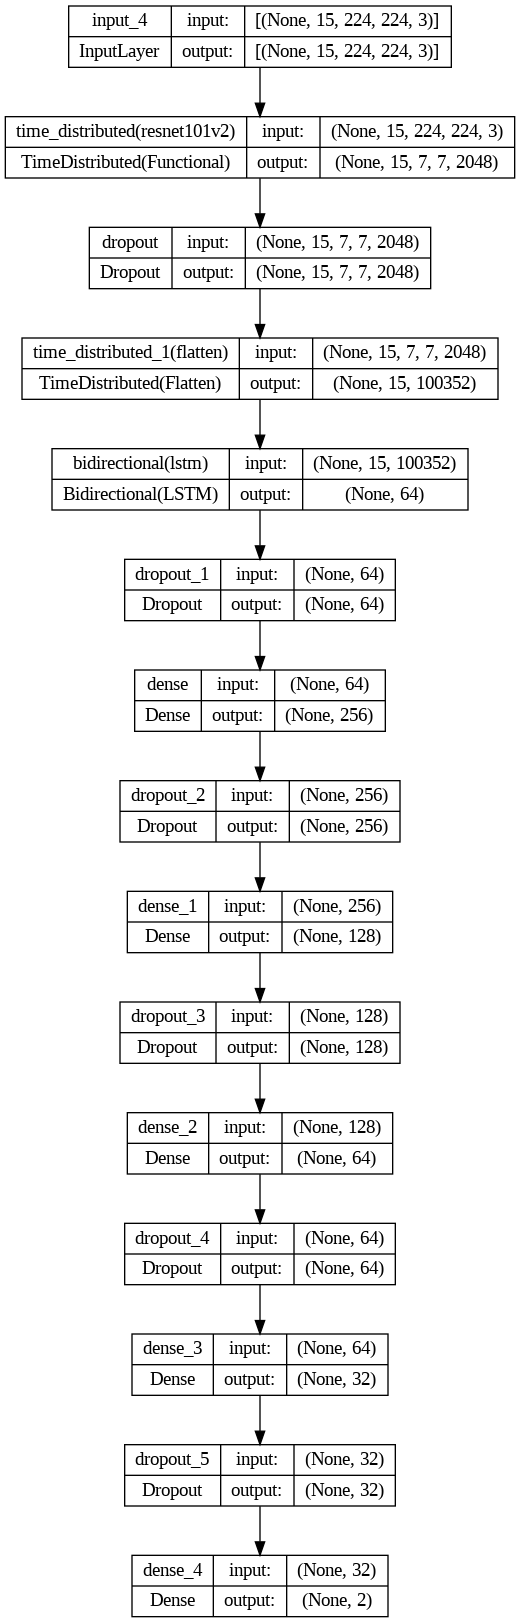

In [26]:
# Constructing the Model
my_LSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(my_LSTM_model, to_file = 'my_LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [27]:
patience = 5

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005

batch_size = 8
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

In [28]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy',
                                        patience = 5, restore_best_weights=True)

# Create checkpoint for model
# Change name for model

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.8,
                                                  patience=3,
                                                  min_lr=0.00001,
                                                  verbose=1)
callbacks = [lr_callback, early_stopping_callback, reduce_lr]

In [29]:
# Fitting the model
my_LSTM_model_history = my_LSTM_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = callbacks)

Epoch 1/20
15/15 [==============================] - 53s 2s/step - loss: 0.7260 - accuracy: 0.4522 - val_loss: 0.6873 - val_accuracy: 0.5862 - lr: 1.0000e-05
Epoch 2/20
15/15 [==============================] - 10s 676ms/step - loss: 0.7052 - accuracy: 0.4957 - val_loss: 0.6864 - val_accuracy: 0.5862 - lr: 1.0800e-04
Epoch 3/20
15/15 [==============================] - 11s 713ms/step - loss: 0.6531 - accuracy: 0.7565 - val_loss: 0.6627 - val_accuracy: 0.7241 - lr: 2.0600e-04
Epoch 4/20
15/15 [==============================] - 11s 759ms/step - loss: 0.6664 - accuracy: 0.5913 - val_loss: 0.6499 - val_accuracy: 0.8276 - lr: 3.0400e-04
Epoch 5/20
15/15 [==============================] - 11s 733ms/step - loss: 0.6271 - accuracy: 0.6522 - val_loss: 0.6170 - val_accuracy: 0.6552 - lr: 4.0200e-04
Epoch 6/20
15/15 [==============================] - 11s 740ms/step - loss: 0.5213 - accuracy: 0.8522 - val_loss: 0.5468 - val_accuracy: 0.7931 - lr: 5.0000e-04
Epoch 7/20
15/15 [=========================

In [30]:
model_evaluation_history = my_LSTM_model.evaluate(features_test, labels_test)

2/2 [==============================] - 33s 4s/step - loss: 0.6438 - accuracy: 0.7222


In [31]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

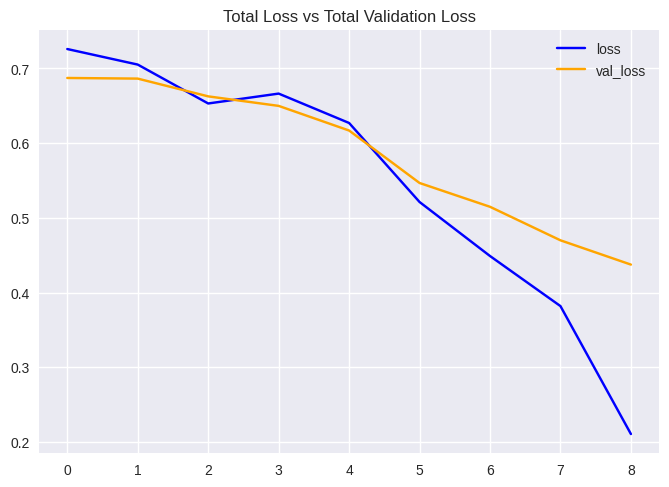

In [32]:
plot_metric(my_LSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

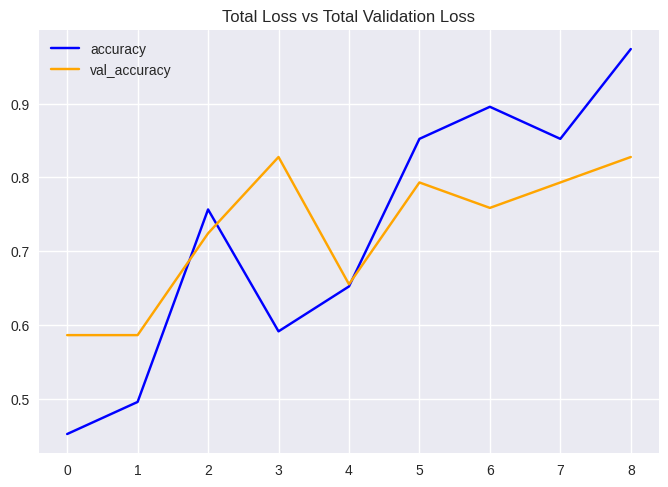

In [33]:
plot_metric(my_LSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [34]:
labels_predict = my_LSTM_model.predict(features_test)

2/2 [==============================] - 7s 37ms/step


In [35]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [36]:
labels_test_normal.shape , labels_predict.shape

((36,), (36,))

In [37]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.7222222222222222


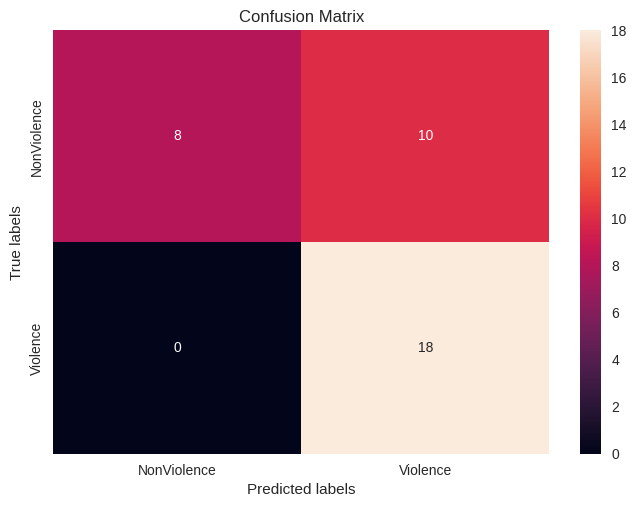

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NonViolence', 'Violence']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

In [48]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       1.00      0.44      0.62        18
           1       0.64      1.00      0.78        18

    accuracy                           0.72        36
   macro avg       0.82      0.72      0.70        36
weighted avg       0.82      0.72      0.70        36

